In [248]:
import numpy as np
import pickle
import math
from scipy.stats import sem
import matplotlib.pyplot as plt
import pandas as pd
import time
import pprint
import seaborn as sns
import statsmodels.formula.api as smf
import CMR_IA as cmr
import scipy as sp
sns.set_context('paper')
plt.style.use("default")
pd.set_option('display.max_columns', None)

In [249]:
with open("../Data/simu6a1_design.pkl", 'rb') as inp:
    df_study = pickle.load(inp)
    df_test = pickle.load(inp)
# df_study = df_study.loc[df_study.session < 500]
# df_test = df_test.loc[df_test.session < 500]

In [250]:
df_study

,study_itemno1,study_itemno2,study_item1,study_item2,list,session
0,1569,1107,VINEGAR,PORCUPINE,0,0
1,30,696,APARTMENT,HEADBAND,0,0
2,1457,1443,THIGH,TECHNICIAN,0,0
3,1331,31,SNACK,APE,0,0
4,1377,1579,STEP,WAIST,0,0
...,...,...,...,...,...,...
25195,1352,239,SPINACH,CAPTAIN,41,99
25196,323,787,CLIMBER,KNOB,41,99
25197,299,1369,CHILD,STALLION,41,99
25198,504,63,DUCK,AWARD,41,99


In [251]:
df_test

,test_itemno,test_item,correct_ans,lag,list,session,order
0,468,DINNER,681,0,0,0,2
1,1579,WAIST,1377,2,0,0,2
2,1331,SNACK,31,4,0,0,1
3,1457,THIGH,1443,6,0,0,1
4,696,HEADBAND,30,8,0,0,2
...,...,...,...,...,...,...,...
25195,63,AWARD,504,2,41,99,2
25196,299,CHILD,1369,4,41,99,1
25197,323,CLIMBER,787,6,41,99,1
25198,239,CAPTAIN,1352,8,41,99,2


### Run CMR-IA

In [252]:
s_mat = np.load('../Data/wordpools/ltp_FR_similarity_matrix.npy')

In [253]:
params = cmr.make_default_params()
params.update(
    beta_enc = 0.7,
    beta_cue = 0.4,
    beta_distract = 0.01,
    beta_rec_post = 0.99,
    beta_rec = 0.5,
    gamma_fc = 0.2,
    gamma_cf = 0.2,
    s_fc = 0.1,
    s_cf = 0.1,
    c_thresh = 0.01,
    kappa = 0.04,
    lamb = 0.02,
    eta = 0.01,
    alpha = 0.9,
    omega = 3,
    phi_s = 1,
    phi_d = 1.3,
    nitems_in_accumulator = 48,
    d_ass = 0.8
)
params

# using parameters from simu5, the figure gives a U shape, because of U shape f_in diff, because primacy
# prob: how to flatten end? how to make initial decrease straight?
# 7.17 phi_s, phi_d could only flatten the last three
# phi_s control the base level and the last node
# phi_d control the last two

{'beta_enc': 0.7,
 'beta_rec': 0.5,
 'beta_cue': 0.4,
 'beta_rec_post': 0.99,
 'beta_distract': 0.01,
 'phi_s': 1,
 'phi_d': 1.3,
 's_cf': 0.1,
 's_fc': 0.1,
 'kappa': 0.04,
 'eta': 0.01,
 'omega': 3,
 'alpha': 0.9,
 'c_thresh': 0.01,
 'c_thresh_itm': 0.5,
 'c_thresh_ass': 0.5,
 'd_ass': 0.8,
 'lamb': 0.02,
 'rec_time_limit': 60000.0,
 'dt': 10,
 'nitems_in_accumulator': 48,
 'max_recalls': 50,
 'learn_while_retrieving': False,
 'a': 2800,
 'b': 20,
 'm': 0,
 'n': 1,
 'c1': 0,
 'thresh_sigma': 0,
 'No_recall': None,
 'var_enc': 1,
 'bad_enc_ratio': 1,
 'gamma_fc': 0.2,
 'gamma_cf': 0.2}

In [254]:
df_simu, f_in, f_dif = cmr.run_norm_cr_multi_sess(params,df_study, df_test ,s_mat)
df_simu

CMR2 Time: 105.52038478851318


,list,session,test_itemno,s_resp,s_rt,csim
0,0,0,468,681.0,1360.0,0.740644
1,0,0,1579,-1.0,-1.0,-1.000000
2,0,0,1331,31.0,4580.0,0.481619
3,0,0,1457,-1.0,-1.0,-1.000000
4,0,0,696,-1.0,-1.0,-1.000000
...,...,...,...,...,...,...
25195,41,99,63,504.0,2250.0,0.536297
25196,41,99,299,-1.0,-1.0,-1.000000
25197,41,99,323,-1.0,-1.0,-1.000000
25198,41,99,239,1369.0,3540.0,0.467039


In [255]:
df_simu = df_simu.merge(df_test,on=['session','list','test_itemno'])
df_simu['correct'] = df_simu.s_resp == df_simu.correct_ans
df_simu

,list,session,test_itemno,s_resp,s_rt,csim,test_item,correct_ans,lag,order,correct
0,0,0,468,681.0,1360.0,0.740644,DINNER,681,0,2,True
1,0,0,1579,-1.0,-1.0,-1.000000,WAIST,1377,2,2,False
2,0,0,1331,31.0,4580.0,0.481619,SNACK,31,4,1,True
3,0,0,1457,-1.0,-1.0,-1.000000,THIGH,1443,6,1,False
4,0,0,696,-1.0,-1.0,-1.000000,HEADBAND,30,8,2,False
...,...,...,...,...,...,...,...,...,...,...,...
25195,41,99,63,504.0,2250.0,0.536297,AWARD,504,2,2,True
25196,41,99,299,-1.0,-1.0,-1.000000,CHILD,1369,4,1,False
25197,41,99,323,-1.0,-1.0,-1.000000,CLIMBER,787,6,1,False
25198,41,99,239,1369.0,3540.0,0.467039,CAPTAIN,1352,8,2,False


In [256]:
sessions = np.unique(df_simu.session)
for sess in sessions:
    df_tmp = df_study.loc[df_study.session == sess]
    tmp1 = df_tmp.study_itemno1.to_numpy()
    tmp2 = df_tmp.study_itemno2.to_numpy()
    tmp = np.concatenate((tmp1, tmp2))
    tmp = np.sort(tmp)
    tmp_test = df_simu.loc[df_study.session == sess,"test_itemno"]
    tmp_corr = df_simu.loc[df_study.session == sess,"correct_ans"]
    testid = np.searchsorted(tmp, tmp_test)
    corrid = np.searchsorted(tmp, tmp_corr)

    df_simu.loc[df_simu.session == sess, 'corr_fin']= [f_dif[sess][i][id] for i, id in enumerate(corrid)]
    # df_simu.loc[df_simu.session == sess, 'omean_fin'] = [np.mean(np.delete(f_dif[sess][i], id)) for i, id in corrid]
    df_simu.loc[df_simu.session == sess, 'omax_fin'] = [np.max(np.delete(f_dif[sess][i], id)) for i, id in enumerate(corrid)]
df_simu

,list,session,test_itemno,s_resp,s_rt,csim,test_item,correct_ans,lag,order,correct,corr_fin,omax_fin
0,0,0,468,681.0,1360.0,0.740644,DINNER,681,0,2,True,-0.306193,-0.535682
1,0,0,1579,-1.0,-1.0,-1.000000,WAIST,1377,2,2,False,-0.608153,-0.632742
2,0,0,1331,31.0,4580.0,0.481619,SNACK,31,4,1,True,-0.557387,-0.622319
3,0,0,1457,-1.0,-1.0,-1.000000,THIGH,1443,6,1,False,-0.617659,-0.642618
4,0,0,696,-1.0,-1.0,-1.000000,HEADBAND,30,8,2,False,-0.585453,-0.616058
...,...,...,...,...,...,...,...,...,...,...,...,...,...
25195,41,99,63,504.0,2250.0,0.536297,AWARD,504,2,2,True,-0.496203,-0.665032
25196,41,99,299,-1.0,-1.0,-1.000000,CHILD,1369,4,1,False,-0.565298,-0.664074
25197,41,99,323,-1.0,-1.0,-1.000000,CLIMBER,787,6,1,False,-0.558802,-0.560350
25198,41,99,239,1369.0,3540.0,0.467039,CAPTAIN,1352,8,2,False,-0.587939,-0.558434


In [257]:
# clean first 2 list
df_simu = df_simu.query("list > 1")
df_simu

,list,session,test_itemno,s_resp,s_rt,csim,test_item,correct_ans,lag,order,correct,corr_fin,omax_fin
12,2,0,887,816.0,1680.0,0.705210,MERMAID,816,0,1,True,-0.370766,-0.518659
13,2,0,10,1101.0,3440.0,0.531356,AGENT,1101,2,1,True,-0.508166,-0.669400
14,2,0,1411,-1.0,-1.0,-1.000000,SUPPER,1561,4,2,False,-0.645570,-0.643136
15,2,0,959,1104.0,3390.0,0.501813,NOTEBOOK,1104,6,2,True,-0.529260,-0.642132
16,2,0,1448,969.0,4870.0,0.447125,TEMPLE,969,8,2,True,-0.569298,-0.688411
...,...,...,...,...,...,...,...,...,...,...,...,...,...
25195,41,99,63,504.0,2250.0,0.536297,AWARD,504,2,2,True,-0.496203,-0.665032
25196,41,99,299,-1.0,-1.0,-1.000000,CHILD,1369,4,1,False,-0.565298,-0.664074
25197,41,99,323,-1.0,-1.0,-1.000000,CLIMBER,787,6,1,False,-0.558802,-0.560350
25198,41,99,239,1369.0,3540.0,0.467039,CAPTAIN,1352,8,2,False,-0.587939,-0.558434


In [258]:
df_fin = df_simu.groupby('lag')[['corr_fin','omax_fin']].mean().reset_index()
df_fin['dif'] = df_fin['corr_fin'] - df_fin['omax_fin']
df_fin

,lag,corr_fin,omax_fin,dif
0,0,-0.348111,-0.547929,0.199818
1,2,-0.571170,-0.653492,0.082322
2,4,-0.600552,-0.636870,0.036318
3,6,-0.594091,-0.610611,0.016520
4,8,-0.583578,-0.598741,0.015163
5,10,-0.570195,-0.593647,0.023451


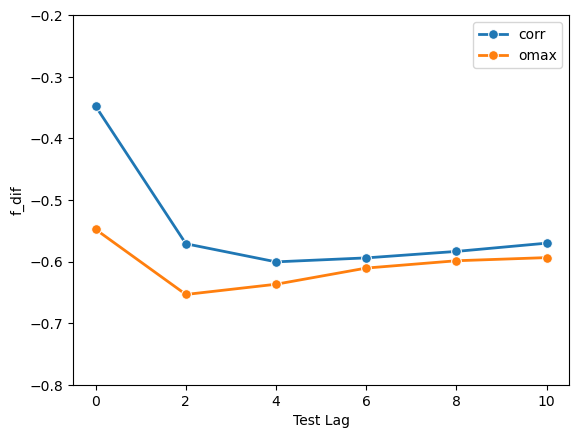

In [259]:
sns.lineplot(data=df_fin, x='lag', y='corr_fin', linewidth=2, marker='o', markersize = 7, label='corr')
# sns.lineplot(data=df_fin, x='lag', y='omean_fin', linewidth=2, marker='o', markersize = 7)
sns.lineplot(data=df_fin, x='lag', y='omax_fin', linewidth=2, marker='o', markersize = 7, label='omax')
plt.ylim([-0.8,-0.2])
plt.xlabel('Test Lag')
plt.ylabel('f_dif')
# plt.savefig('fig/simu3_hr.pdf')
plt.show()

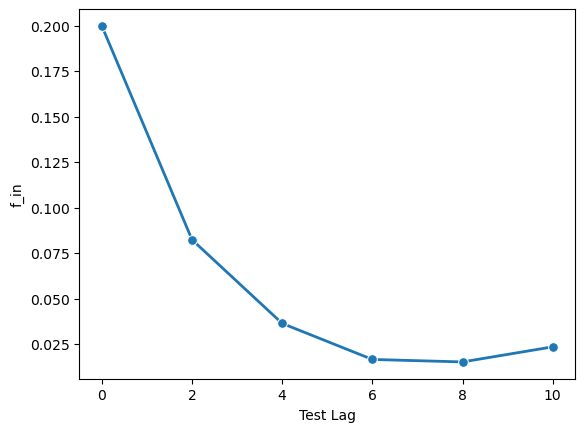

In [260]:
sns.lineplot(data=df_fin, x='lag', y='dif', linewidth=2, marker='o', markersize = 7)
# plt.ylim([0,1])
plt.xlabel('Test Lag')
plt.ylabel('f_in')
# plt.savefig('fig/simu3_hr.pdf')
plt.show()

### PLOT

In [261]:
df_laggp = df_simu.groupby(['lag','order']).correct.mean().to_frame(name='corr_rate').reset_index()
df_laggp

,lag,order,corr_rate
0,0,1,0.971760
1,0,2,0.978185
2,2,1,0.676573
3,2,2,0.702171
4,4,1,0.393526
5,4,2,0.408304
6,6,1,0.279175
7,6,2,0.271372
8,8,1,0.251340
9,8,2,0.246020


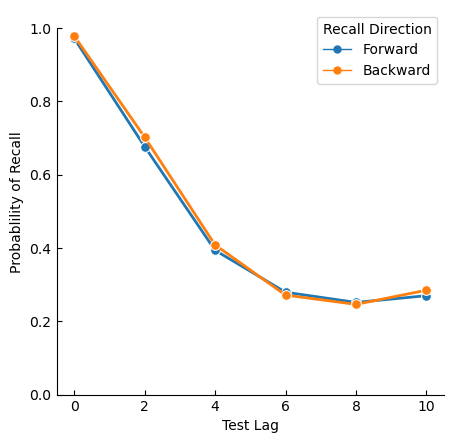

In [263]:
from matplotlib.lines import Line2D

fig,ax = plt.subplots(figsize=(5,5))
ax.spines['left'].set_bounds(0, 1)
ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(axis="y",direction="in")
ax.tick_params(axis="x",direction="in")
sns.lineplot(data=df_laggp, x='lag', y='corr_rate', linewidth=2, marker='o', markersize = 7, hue='order',palette='tab10')
plt.ylim([0,1.05])
plt.xlabel('Test Lag')
plt.ylabel('Probablility of Recall')
legend_elements = [Line2D([0], [0], color = sns.color_palette()[0], lw=1, marker='o',
                          markersize = 5, linestyle='-',label = 'Forward'),
                   Line2D([0], [0], color = sns.color_palette()[1], lw=1, marker='o',
                          markersize = 5, linestyle='-', label = 'Backward')]
L = plt.legend(handles = legend_elements, title='Recall Direction',loc='upper right')
# L.get_texts()[0].set_text('Forward')
# L.get_texts()[1].set_text('Backward')
plt.savefig('fig/simu6a_recall.pdf')
plt.show()